In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import numpy as np
import xarray as xr
import cmocean.cm as cm

def make_dataset(q, x, y, t, u, v):
    
    ds = xr.Dataset(
        {'q': (('time', 'x', 'y'), q),
         'u': (('x', 'y'), u),
         'v': (('x', 'y'), v)},
        {'time': t, 'x': x, 'y': y},
    )
    ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
    ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
    ds['y'].attrs.update({'long_name': 'y-coordinate', 'units': 'm'})
    ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
    ds['v'].attrs.update({'long_name': 'meridional wind', 'units': 'm/s'})
    ds.attrs.update({
        'Conventions': 'CF-1.7'
    })

    return ds

/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


The purpose of this notebook is to document some of my work in prototyping a useful advection scheme for use within NowCast 1.0. 

# Analytical Test Case

Sample problem (inspired by [here]:(http://geodynamics.usc.edu/~becker/teaching/557/problem_sets/problem_set_fd_advection.pdf))

$$u(x, y) = y$$
$$v(x, y) = -x$$

Assume an initial Gaussian tracer distribution 

$$F(x, y) = 2\exp\left(\frac{(x+0.25)^2+z^2}{0.1^2}\right)$$

with $x \in \left[-0.5,\,0.5\right]$ and $y \in \left[-0.5,\,0.5\right]$

/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:35: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


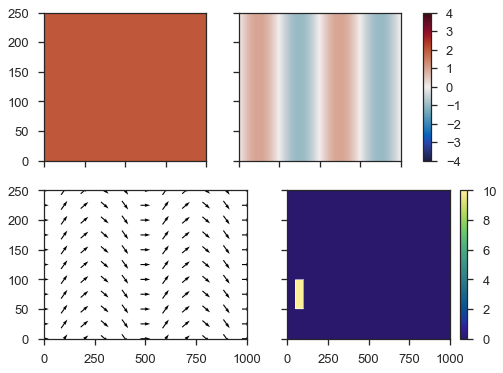

In [26]:
from nowcast.test_functions import eddy, wavy_flow, gaussian, hat, slotted_cylinder

f = 10
nx, ny = 50*f*4, 50*f
Δx, Δy = 5./f, 5./f
x = np.arange(0, (nx+1)*Δx, Δx)
y = np.arange(0, (ny+1)*Δy, Δy)
xx, yy = np.meshgrid(x, y)
xx, yy = xx.T, yy.T

# u, v = eddy(xx, yy, A=4.)
u, v = wavy_flow(xx, yy, Ax=2., Ay=1., Tx=2)
A = 10
# F = slotted_cylinder(xx, yy, x[13*f], y[37*f], r=25, A=A)
# F = gaussian(xx, yy, A=10., x0=x[13*f], y0=y[37*f], sigmax=Δx*3*f, sigmay=Δy*3*f)
F = hat(xx, yy, A=10., xbnds=[x[10*f], x[20*f]], ybnds=[y[10*f], y[20*f]])


fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
axu, axv, axvec, axf = axs.flatten()[:]

vv = 4.
cf = axu.pcolormesh(xx, yy, u, vmin=-vv, vmax=vv, cmap=cm.balance)
_ = axv.pcolormesh(xx, yy, v, vmin=-vv, vmax=vv, cmap=cm.balance)
plt.colorbar(cf, ax=[axu, axv])

max_q = 10
rsx = nx // max_q
rsy = ny // max_q
axvec.quiver(xx[::rsx, ::rsy], yy[::rsx, ::rsy], u[::rsx, ::rsy], v[::rsx, ::rsy], 
             angles='xy', pivot='mid')

cf = axf.pcolormesh(xx, yy, F, vmin=0, vmax=A, cmap=cm.haline)
axf.contour(xx, yy, F, levels=np.linspace(0, A+0.1, A/2), linewidths=0.25, colors='w')
plt.colorbar(cf, ax=axf)

# Algorithm Notes

## TITAN (Seed, 2003)

The algorithm implemented in TITAN is a simple, backwards semi-Lagrangian scheme. It makes a single constant-vector backward step as a displacement vector and then uses bilinear interpolation to source the new upstream data. Following the formulation in Germann and Zawadzki (2002):

1. Compute the displacement vector at the point of interest, $$ \alpha = \tau\mathbf{u}(t_0, \mathbf{x}_p) $$ where $\tau$ is the advection timestep, and $\mathbf{u}(t_0, \mathbf{x}_p)$ is the echo motion at a grid point $p$.
2. Compute the source point, $$ \mathbf{x}_s = \alpha + \mathbf{x}_p $$
3. Estimate the echo field at the source point, $$ F_s = F(\mathbf{x}_s) $$ using a local interpolation scheme
4. Copy the source value into the update of $F$ a the point of interest, $$ F(t+\Delta t, \mathbf{x}_p) = F_s $$

## Original Implementation

The following is, essentially, a verbatim translation of the TITAN C++ source to Python+numba. It's quite efficient, since numba should be able to inline the array-lookup helper functions, and numba has direct memory access into NumPy arrays (does not need to go through CPython). I've annotated the functions with useful docstrings, for reference purposes.

It's *highly* performant. With minimal re-writing, it can also likely be re-factored for computation on a GPU.

In [27]:
from numba import jit, njit, prange
from numpy import isnan, floor
from itertools import product

BACKGROUND = 0
DEBUG = False

from scipy.interpolate import RectBivariateSpline
# _from_rectbivariatespline = RectBivariateSpline(x, y, field)
# print(_from_interp2d(x1, y1))
# print(_from_rectbivariatespline([x1, ], [y1, ]))

@njit
def get_pixel(arr, i, j, bkg=BACKGROUND):
    """ Safely access an arbitrary index from a 2D array.
    
    Parameters
    ----------
    arr : numpy.ndarray of rank 2
        The data array to access
    i, j : int
        Integer indices in the x- (columns) and y-directions (rows), respectively
    bkg : float
        A backup, "safety" value to return.
        
    Returns
    -------
    Array accessed at index (i, j), or the background value if this is out of bounds
    
    """
    nx, ny = arr.shape
    # print(">>", (i, nx), (j, ny))
    if ((i < 0) or (i >= nx) or
        (j < 0) or (j >= ny) or
        (isnan(arr[i,j]))):
        return bkg
    else:
        return arr[i,j]
    
    
@njit
def replace_nan(val, bkg=BACKGROUND):
    """ Return value or a safety (background) value if value is NaN. """
    if isnan(val): return bkg
    else: return val

    
@njit
def pixel_mask(arr, src_x, src_y, bkg=BACKGROUND):
    """ Perform bilinear interpolation to a fractional pixel location
    into an array.
    
    Parameters
    ----------
    arr : numpy.ndarray of rank 2
        The data array to access
    src_{x, y} : float
        Fractional indices in the x- (columns) and y-directions (rows) to
        interpolate to
    bkg : float
        A backup, "safety" value to return
    
    Returns
    -------
    Field represented by array, accessed at coordinates corresponding to the
    fractional multi-index (src_x, src_y)
    
    """

    d = DEBUG
    
    # if d: print(" -- PIXEL MASK -- ")    
    nx, ny = arr.shape
    # if d: print(">         (nx, ny) :", (nx, ny))
    
    # Integer coordinates of the new source bin
    src_i = int(floor(src_x))
    src_j = int(floor(src_y))
    # if d: print(">   (src_i, src_j) :", src_i, src_j)
    
    # Determine fractional contributions of each pixel under the source mask
    frac_i = 1.0 + src_i - src_x
    frac_j = 1.0 + src_j - src_y
    # if d: print("> (frac_i, frac_j) :", frac_i, frac_j) 
    
    # If any of the source pixel mask is outside domain do the slow case
    if ( (src_i < 0) or (src_i >= (nx-1)) or
         (src_j < 0) or (src_j >= (ny-1)) ):
        # If all the source pixels are outside, just set to border value
        if ( (src_i < -1) or (src_i >= nx) or
             (src_j < -1) or (src_j >= ny) ):
            return bkg
        else:
            # At least one good pixel.
            ret_val = (
                   frac_i      *    frac_j      * get_pixel(arr, src_i, src_j, bkg)
              +    frac_i      * (1.0 - frac_j) * get_pixel(arr, src_i, src_j+1, bkg)
              + (1.0 - frac_i) *    frac_j      * get_pixel(arr, src_i+1, src_j, bkg)
              + (1.0 - frac_i) * (1.0 - frac_j) * get_pixel(arr, src_i+1, src_j+1, bkg)  
            )
    else:
        # Normal case - use all 4 pixels.
        ret_val = (
               frac_i      *    frac_j      * replace_nan(arr[src_i, src_j], bkg)
          +    frac_i      * (1.0 - frac_j) * replace_nan(arr[src_i, src_j+1], bkg)
          + (1.0 - frac_i) *    frac_j      * replace_nan(arr[src_i+1, src_j], bkg)
          + (1.0 - frac_i) * (1.0 - frac_j) * replace_nan(arr[src_i+1, src_j+1], bkg)  
        )
        # if d:
        #     for fi, fj, si, sj in ([
        #         (frac_i, frac_j, src_i, src_j), 
        #         (frac_i, 1.0-frac_j, src_i, src_j+1), 
        #         (1.0-frac_i, frac_j, src_i+1, src_j), 
        #         (1.0-frac_i, 1.0-frac_j, src_i+1, src_j+1)
        #     ]):
        #         print(" ({:d}, {:d}) - {:f} {:f}: {:f}".format(si, sj, fi, fj, arr[si, sj]))

    # if d: print(" -- ----- ---- -- ")    
        
    return ret_val


@jit(nopython=True, parallel=True)
def advect_field(flow_u, flow_v, data, dx=Δx, dy=Δy, dt=5.0, ij=(-1, -1), bkg=BACKGROUND):
    """ Compute linear, constant-vector backwards semi-Lagrangian advection step 
    of the given flow and data fields.
    
    Parameters
    ----------
    flow_{u, v} : numpy.ndarrays rank 2
        U and V components of the vector field, in m/s
    data : numpy.ndarray of rank 2
        The tracer field to advect along with the given flow field.
    d{x, y} : floats
        Constant grid-spacing in the x- and y- directions, in m
    dt : float
        Advection time step, in s
    ij : 2-tuple of ints
        Short-circuit the aglorithm by computing the backwards step and interpolant
        at the indicated grid location
        
    Returns
    -------
    Rank-2 array containing the advected flow after a time of `dt` seconds
    
    """
    
    new_data = np.ones_like(data)*bkg
    nx, ny = new_data.shape
    
    i, j = ij
    if ((i != -1) and (j != -1)):
        print("       dt :", dt)
        print("   (i, j) :", (i, j))
        print("  dt*u/dx :", dt*flow_u[i,j]/dx)
        print("  dt*v/dy :", dt*flow_v[i,j]/dy)
        _ = pixel_mask(data, i - dt*flow_u[i,j]/dx, j - dt*flow_v[i,j]/dy, bkg)
    
    else:
        for j in range(0, ny):
            for i in range(0, nx):
                new_data[i,j] = pixel_mask(data, i - dt*flow_u[i,j]/dx, j - dt*flow_v[i,j]/dy, bkg)
        # for j, i in prange(product(range(0, ny), range(0, nx))):
        #     new_data[i, j] = pixel_mask(data, i - dt*flow_u[i,j]/dx, j - dt*flow_v[i,j]/dy, bkg)
            
    return new_data

In [23]:
i, j = 7*f, 37*f
dt = 2.5
_ = advect_field(u, v, F, dt=dt, ij=(10, 10))

_x0, _y0 = x[i], y[j]
print("(x0, y0) :", _x0, _y0)
dx, dy = dt*u[i,j], dt*v[i,j]
print("(dx, dy) :", dx, dy)
print("(x0-dx, y0-dy) :", _x0-dx, _y0-dy)
print("F(x0, y0)) :", F[i, j])

       dt : 2.5
   (i, j) : (10, 10)
  dt*u/dx : 10.0
  dt*v/dy : 0.6279051952931337
(x0, y0) : 35.0 185.0
(dx, dy) : 5.0 2.12889645783
(x0-dx, y0-dy) : 30.0 182.871103542
F(x0, y0)) : 0.0


We'll begin by trying to work out the application of the semi-Lagrangian formulation proposed by [Robert (1981)](https://doi.org/10.1080/07055900.1981.9649098). Robert's work originally applied to the vorticity equation,

$$\frac{\partial Q}{\partial t} + u\frac{\partial Q}{\partial x} + v\frac{\partial Q}{\partial y} + R$$

which are approximated by the coupled equations

$$\begin{align*}
Q(x,y,t+\Delta t) &= Q(x-2a,y-2b,t-\Delta t) + 2\Delta tR(x-a, y-b, t) \\
a &= \Delta t u(x-a, y-b, t) \\
b &= \Delta t v(x-a, y-b, t)
\end{align*}$$

Here, $a$ and $b$ have to be determined iteratively. Then, upstream values of $u$, $v$, $Q$, and $R$ are obtained via interpolation over a specified regular grid - specifically, bicubic interpolation involving fitting the curve

$$F(x, y)=\sum\limits_{i=0}^3\sum\limits_{j=0}^3A_{i,j}x^iy^j$$

to the 16 points of a 4x4 grid containing the point for which a value is desired at the center of the square. If an upstream point is located outside of the grid, the value at the nearest boundary point is used.

In [28]:
Fp = F.copy()
dt = 25.
Fps = [Fp, ]

t_end = 360
t, i = 0, 0
ts = [t, ]
while t < t_end:
    print("({:3d} {:3.1f}s)".format(i, t))

    Fp = advect_field(u, v, Fps[-1], dt=dt)    
    
    Fps.append(Fp)
    ts.append(t+dt)
    
    i += 1
    t += dt
print("... done", t)

ds = make_dataset(Fps, x, y, ts, u, v)

(  0 0.0s)
(  1 25.0s)
(  2 50.0s)
(  3 75.0s)
(  4 100.0s)
(  5 125.0s)
(  6 150.0s)
(  7 175.0s)
(  8 200.0s)
(  9 225.0s)
( 10 250.0s)
( 11 275.0s)
( 12 300.0s)
( 13 325.0s)
( 14 350.0s)
... done 375.0


In [29]:
ds.to_netcdf('hat.cv.bilinear.wavy.nc')

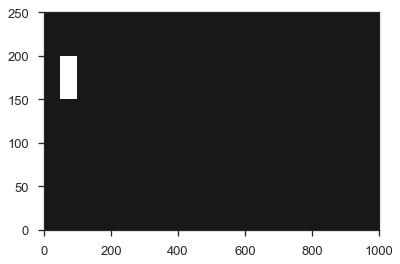

In [20]:
plt.pcolormesh(xx, yy, Fp - F)

/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


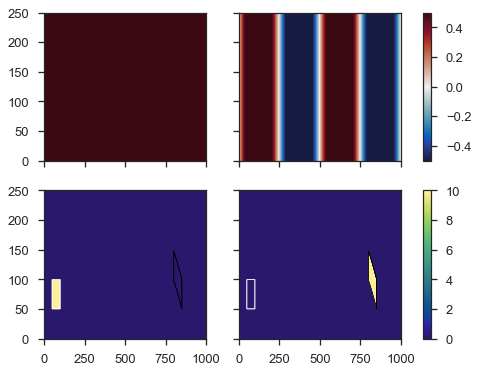

In [30]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
axu, axv, axf, axfp = axs.flatten()[:]

cf = axu.pcolormesh(xx, yy, u, vmin=-0.5, vmax=0.5, cmap=cm.balance)
_ = axv.pcolormesh(xx, yy, v, vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.colorbar(cf, ax=[axu, axv])

cf = axf.pcolormesh(xx, yy, F, vmin=0, vmax=A, cmap=cm.haline)
axf.contour(xx, yy, F, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='w')
axf.contour(xx, yy, Fp, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='k')
_ = axfp.pcolormesh(xx, yy, Fp, vmin=0, vmax=A, cmap=cm.haline)
axfp.contour(xx, yy, F, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='w')
axfp.contour(xx, yy, Fp, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='k')
plt.colorbar(cf, ax=[axf, axfp])

### Interpolation w/ SciPy

In [8]:
i, j = 7, 37
dt = 2.5
_ = advect_field(u, v, F, dt=dt, ij=(i, j))

_x0, _y0 = x[i], y[j]
print("(x0, y0) :", _x0, _y0)
dx, dy = dt*u[i,j], dt*v[i,j]
print("(dx, dy) :", dx, dy)
print("(x0-dx, y0-dy) :", _x0-dx, _y0-dy)
print("F(x0, y0)) :", F[i, j])

       dt : 2.5
   (i, j) : (7, 37)
  dt*u/dx : -17.04
  dt*v/dy : 19.439999999999998
(x0, y0) : 3.5 18.5
(dx, dy) : -8.52 9.72
(x0-dx, y0-dy) : 12.02 8.78
F(x0, y0)) : 0.0


In [10]:
from scipy.interpolate import interp2d
interpolator2 = interp2d(xx.ravel(), yy.ravel(), F)
interpolator3 = interp2d(xx.ravel(), yy.ravel(), F, 'cubic')
print(interpolator2([_x0-dx, ], [_y0-dy, ], assume_sorted=True))
print(interpolator3([_x0-dx, ], [_y0-dy, ], assume_sorted=True))

MemoryError: 

In [11]:
from scipy.interpolate import interp2d, RectBivariateSpline, bisplev, bisplrep

print(F[i-1, j-1])
bisp2 = RectBivariateSpline(x, y, F, kx=1, ky=1)
bisp3 = RectBivariateSpline(x, y, F, kx=3, ky=3)
print(bisp2([_x0-dx, ], [_y0-dy, ]))
print(bisp3([_x0-dx, ], [_y0-dy, ]))

0.0
[[ 0.]]
[[ -6.96618207e-206]]


## Bi-cubic interpolation Extension

Our goal here is to implement point-wise bicubic interpolation of a 2D dataset as a means to have an alternative tool for assessing advection scheme accuracy.

In [8]:
i, j = 7*f, 37*f
print("(i, j) :", i, j)
dt = 2.5
_x0, _y0 = x[i], y[j]
print("(x0, y0) :", _x0, _y0)
dx, dy = dt*u[i,j], dt*v[i,j]

print("(dx, dy) :", dx, dy)
print("(x0-dx, y0-dy) :", _x0-dx, _y0-dy)
print("F(x0, y0)) :", F[i, j])

# Compute displacement vector (metric)
alpha = np.array([dx, dy])
print("α :", alpha)
# integral
beta = alpha/np.array([Δx, Δy])
print("β :", beta)
# Compute new point
x1, y1 = _x0 - alpha[0], _y0 - alpha[1]
print("(x1, y1) :", x1, y1)
i1, j1 = i - beta[0], j - beta[1]
print("(i1, j1) :", i1, j1)

(i, j) : 70 370
(x0, y0) : 35.0 185.0
(dx, dy) : 4.8 7.2
(x0-dx, y0-dy) : 30.2 177.8
F(x0, y0)) : 0.0
α : [ 4.8  7.2]
β : [  9.6  14.4]
(x1, y1) : 30.2 177.8
(i1, j1) : 60.4 355.6


### The basics

Now we can look at a matrix of what the field values bracketing this point look like. We'll use the $u$ field as our example.

In [9]:
from numpy import floor, ceil

ilo, ihi = floor(i1).astype(int), ceil(i1).astype(int)
jlo, jhi = floor(j1).astype(int), ceil(j1).astype(int)
xlo, xhi = x[ilo], x[ihi]
ylo, yhi = y[jlo], y[jhi]

field = u.copy()

print("(i1, j1) :", i1, j1)
for _i, _j in [(ilo, jlo), (ilo, jhi), (ihi, jlo), (ihi, jhi)]:
    print("({:3d}, {:3d}) | {:2.4f}".format(_i, _j, field[_i, _j]))
    
print(pixel_mask(u, i1, j1))

(i1, j1) : 60.4 355.6
( 60, 355) | 1.6800
( 60, 356) | 1.6960
( 61, 355) | 1.6800
( 61, 356) | 1.6960
1.6896000000000004


The next step is to compute the gradients and cross-gradient of our field. We'll use centered differences for this.

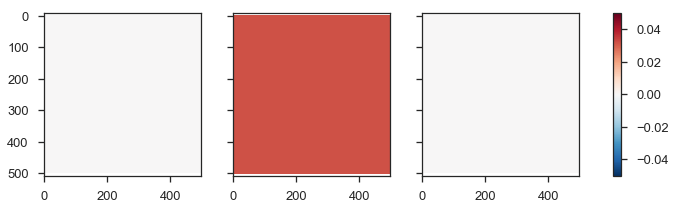

In [10]:
dfield_dx = (field[2:, :] - field[:-2, :])/2./Δx
dfield_dy = (field[:, 2:] - field[:, :-2])/2./Δy
dfield_dxdy = (dfield_dx[:, 2:] - dfield_dx[:, :-2])/2./Δy

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3))
axl, axm, axr = axs
vv = 0.05
cmap_kws = dict(vmin=-vv, vmax=vv, cmap='RdBu_r')
cf = axl.imshow(dfield_dx, **cmap_kws)
axm.imshow(dfield_dy, **cmap_kws)
axr.imshow(dfield_dxdy, **cmap_kws)
plt.colorbar(cf, ax=axs)

The rest of the algorithm is a bit complicated, but has been pre-tabulated and documented in Numerical Recipes. I'll try to crudely implement them here.

In [11]:
# Loop through the corners, counter-clockwise starting from the bottom left
_y, _y1, _y2, _y12 = np.ones(4), np.ones(4), np.ones(4), np.ones(4)
ct = 0
for _i, _j in [(ihi, jlo), (ilo, jlo), (ilo, jhi), (ihi, jhi)]:
    print(_i, _j)
    _y[ct] = field[_i, _j]
    _y1[ct] = dfield_dx[_i, _j]
    _y2[ct] = dfield_dy[_i, _j]
    _y12[ct] = dfield_dxdy[_i, _j]
    ct += 1

61 355
60 355
60 356
61 356


As a test case, let's interpolate some funky data.

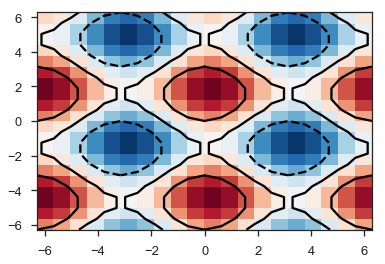

In [12]:
nn = 21

# # Rosenbrock function
# tx = np.linspace(-2, 2, nn)
# ty = np.linspace(-1, 3, nn)
# txx, tyy = np.meshgrid(tx, ty)
# txx, tyy = txx.T, tyy.T
# a, b = 1., 100.
# def _fx(x, y):
#     return (a-x)**2 + b*(y - x**2)**2
# fx = _fx(txx, tyy)
# plt.pcolormesh(tx, ty, fx, vmin=0, vmax=1500, cmap='viridis')
# plt.contour(tx, ty, fx, levels=range(0, 2501, 500), colors='k')

# Wavy function
tx = np.linspace(-2*np.pi, 2*np.pi, nn)
ty = np.linspace(-2*np.pi, 2*np.pi, nn)
txx, tyy = np.meshgrid(tx, ty)
txx, tyy = txx.T, tyy.T
def _fx(x, y):
    return np.sin(x) + np.cos(y)
fx = _fx(txx, tyy)
plt.pcolormesh(tx, ty, fx, vmin=-2, vmax=2, cmap='RdBu_r')
plt.contour(tx, ty, fx, levels=range(-2, 3), colors='k')



### Fortran reference

From Numerical Recipes Second Edition (Fortran 90)

In [13]:
%load_ext fortranmagic

/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [14]:
%%fortran --verbosity
SUBROUTINE fbcuint(y,y1,y2,y12,x1l,x1u,x2l,x2u,x1,x2,ansy,ansy1,ansy2)
!USE nrtype; USE nrutil, ONLY : nrerror
!USE nr, ONLY : bcucof
IMPLICIT NONE
REAL, DIMENSION(4), INTENT(IN) :: y,y1,y2,y12
REAL, INTENT(IN) :: x1l,x1u,x2l,x2u,x1,x2
REAL, INTENT(OUT) :: ansy,ansy1,ansy2
INTEGER :: i
REAL :: t,u
REAL :: d1, d2
REAL, DIMENSION(4,4) :: c
REAL, DIMENSION(16) :: x
REAL, DIMENSION(16,16) :: wt

DATA wt /1,0,-3,2,4*0,-3,0,9,-6,2,0,-6,4,&
8*0,3,0,-9,6,-2,0,6,-4,10*0,9,-6,2*0,-6,4,2*0,3,-2,6*0,-9,6,&
2*0,6,-4,4*0,1,0,-3,2,-2,0,6,-4,1,0,-3,2,8*0,-1,0,3,-2,1,0,-3,&
2,10*0,-3,2,2*0,3,-2,6*0,3,-2,2*0,-6,4,2*0,3,-2,0,1,-2,1,5*0,&
-3,6,-3,0,2,-4,2,9*0,3,-6,3,0,-2,4,-2,10*0,-3,3,2*0,2,-2,2*0,&
-1,1,6*0,3,-3,2*0,-2,2,5*0,1,-2,1,0,-2,4,-2,0,1,-2,1,9*0,-1,2,&
-1,0,1,-2,1,10*0,1,-1,2*0,-1,1,6*0,-1,1,2*0,2,-2,2*0,-1,1/
!call bcucof(y,y1,y2,y12,x1u-x1l,x2u-x2l,c)
d1 = x1u-x1l
d2 = x2u-x2l
x(1:4)=y
x(5:8)=y1*d1
x(9:12)=y2*d2
x(13:16)=y12*d1*d2
x=matmul(wt,x)
c=reshape(x,(/4,4/),order=(/2,1/))

t=(x1-x1l)/(x1u-x1l)
u=(x2-x2l)/(x2u-x2l)
ansy=0.0
ansy2=0.0
ansy1=0.0
do i=4,1,-1
    ansy=t*ansy+((c(i,4)*u+c(i,3))*u+c(i,2))*u+c(i,1)
    ansy2=t*ansy2+(3.0*c(i,4)*u+2.0*c(i,3))*u+c(i,2)
    ansy1=u*ansy1+(3.0*c(4,i)*t+2.0*c(3,i))*t+c(2,i)
end do
ansy1=ansy1/(x1u-x1l)
ansy2=ansy2/(x2u-x2l)
END SUBROUTINE fbcuint



Ok. The following fortran objects are ready to use: fbcuint


### Python version

In [15]:
from numba import njit

# This is from NRv2
WT = np.array([
    1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,
    -3,0,0,3,0,0,0,0,-2,0,0,-1,0,0,0,0,
    2,0,0,-2,0,0,0,0,1,0,0,1,0,0,0,0,
    0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,
    0,0,0,0,-3,0,0,3,0,0,0,0,-2,0,0,-1,
    0,0,0,0,2,0,0,-2,0,0,0,0,1,0,0,1,
    -3,3,0,0,-2,-1,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,-3,3,0,0,-2,-1,0,0,
    9,-9,9,-9,6,3,-3,-6,6,-6,-3,3,4,2,1,2,
    -6,6,-6,6,-4,-2,2,4,-3,3,3,-3,-2,-1,-1,-2,
    2,-2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,2,-2,0,0,1,1,0,0,
    -6,6,-6,6,-3,-3,3,3,-4,4,2,-2,-2,-2,-1,-1,
    4,-4,4,-4,2,2,-2,-2,2,-2,-2,2,1,1,1,1
]).astype(float).reshape((16, 16))

@njit#("f8[:,:](f8[:], f8[:], f8[:], f8[:], f8, f8)")
def _bcucof(y, y1, y2, y12, d1, d2):
    """ Given arrays y, y1, y2, y12, each of length 4, containing
    the function, gradients, and cross derivative at the four grid points
    of a rectangular grid cell (numbered counterclockwise from lower left),
    and given d1 and d2, the length of the grid cell in the 1- and 2- directions,
    return the 4x4 table c necessary for bcuint to perform bicubic interpolation.
    
    This has been adapted from the similarly named subroutine in the F90 
    release of Numerical Recipes, v2
    
    """
    # Pack a temporary vector x
    x = np.ones(16)
    x[:4] = y
    x[4:8] = y1*d1
    x[8:12] = y2*d2
    x[12:16] = y12*d1*d2
    
    # Matrix multiple the stored table
    c = WT @ x
    
    # Unpack the result into the output table
    c = c.reshape((4, 4))
    
    return c
# c = _bcucof(_y, _y1, _y2, _y12, Δx, Δy)

In [17]:
%timeit _bcucof(_y, _y1, _y2, _y12, Δx, Δy)

2.56 µs ± 131 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [88]:
@njit("f8(f8[:], f8[:], f8[:], f8[:], f8, f8, f8, f8, f8, f8)", nogil=True)
def _bcuint(y, y1, y2, y12, x1l, x1u, x2l, x2u, x1, x2):
    """ Bicubic interpolation within a grid square. 
    
    Input quantities are y,y1,y2,y12 (as described in bcucof); 
    x1l and x1u, the lower and upper coordinates of the grid square 
    in the 1- direction; x2l and x2u likewise for the 2-direction; 
    and x1,x2, the coordinates of the desired point for the interpolation. 
    The interpolated function value is returned as ansy, and the 
    interpolated gradient values as ansy1 and ansy2. 
    
    This routine calls bcucof.
    
    This has been adapted from the similarly named subroutine in the F90 
    release of Numerical Recipes, v2
    
    """
    
    # Get the c's
    c = _bcucof(y, y1, y2, y12, x1u-x1l, x2u-x2l)
    # print('c :', c)
    
    # Translate coordinates follow NRv2 Equation (3.6.4)
    t = (x1 - x1l) / (x1u - x1l)
    # print('t :', t, x1, x1l, x1u)
    u = (x2 - x2l) / (x2u - x2l)
    # print('u :', u)
    
    ansy = 0.
    # ansy2 = 0.
    # ansy1 = 0.
    for i in range(3, -1, -1):
        ansy = t*ansy + ((c[i,3]*u + c[i,2])*u + c[i,1])*u + c[i,0]
        # ansy2 = t*ansy2 + (3.*c[i,3]*u + 2.*c[i,2])*u + c[i,1]
        # ansy1 = u*ansy1 + (3.*c[3,i]*t + 2.*c[2,i])*t + c[1,i]
    # ansy1 = ansy1 / (x1u - x1l)
    # ansy2 = ansy2 / (x2u - x2l)
    
    return ansy #, ansy1, ansy2  
# a = _bcuint(_y, _y1, _y2, _y12, xlo, xhi, ylo, yhi, x1, y1)
# print(a)

In [89]:
%timeit _bcuint(_y, _y1, _y2, _y12, xlo, xhi, ylo, yhi, x1, y1)

3.25 µs ± 93.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [143]:
from numpy import floor, ceil

@njit("f8(f8[:], f8[:], f8[:,:], f8, f8, f8, f8)", nogil=True)
def bicubic_interp(x, y, field, xp, yp, dx=Δx, dy=Δy):
        
    # Compute the fractional integer index of the point in question
    i1, j1 = (xp - x[0])/dx, (yp - y[0])/dy
        
    # Set up the interpolation square
    ilo, ihi = int(floor(i1)), int(ceil(i1))
    jlo, jhi = int(floor(j1)), int(ceil(j1))
    xlo, xhi = x[ilo], x[ihi]
    ylo, yhi = y[jlo], y[jhi]
    
    # Corner case - this should only happen if we're in upper-left
    # corner of the grid, but it will eventually lead to a divide by 
    # zero error. So we should just return the corner grid cell value.
    if ((ilo == ihi) or (jlo == jhi)):
        return field[0, 0]
            
    dfield_dx = (field[2:, :] - field[:-2, :])/2./dx
    dfield_dy = (field[:, 2:] - field[:, :-2])/2./dy
    dfield_dxdy = (dfield_dx[:, 2:] - dfield_dx[:, :-2])/2./dy
    
    # Loop through the corners, counter-clockwise starting from the bottom left
    _y, _y1, _y2, _y12 = np.ones(4), np.ones(4), np.ones(4), np.ones(4)
    ct = 0
    corners = [(ilo, jlo), (ihi, jlo), (ihi, jhi), (ilo, jhi)]
    for _i, _j in corners:
        _y[ct] = field[_i, _j]
        # Note the dimensionality reduction in the arrays below - 
        # we used centered differences, which cleaved off a halo of
        # width 1, so we need to add that back in when we index into
        # the derivative arrays
        _y1[ct] = dfield_dx[_i-1, _j]
        _y2[ct] = dfield_dy[_i, _j-1]
        _y12[ct] = dfield_dxdy[_i-1, _j-1]
        ct += 1

    return _bcuint(_y, _y1, _y2, _y12, xlo, xhi, ylo, yhi, xp, yp)


@njit("f8(f8[:], f8[:], f8[:,:],  f8[:,:], f8[:,:], f8[:,:], f8, f8, f8, f8)", nogil=True)
def bicubic_interp2(x, y, field, dfx, dfy, dfxy, xp, yp, dx=Δx, dy=Δy):
    """ Similar to bicubic_interp but requires the derivatives to be passed to 
    the routine (not computed on the fly) """
        
    # Compute the fractional integer index of the point in question
    i1, j1 = (xp - x[0])/dx, (yp - y[0])/dy
        
    # Set up the interpolation square
    ilo, ihi = int(floor(i1)), int(ceil(i1))
    jlo, jhi = int(floor(j1)), int(ceil(j1))
    xlo, xhi = x[ilo], x[ihi]
    ylo, yhi = y[jlo], y[jhi]
    
    # Corner case - this should only happen if we're in upper-left
    # corner of the grid, but it will eventually lead to a divide by 
    # zero error. So we should just return the corner grid cell value.
    if ((ilo == ihi) or (jlo == jhi)):
        return field[0, 0]
    
    # Loop through the corners, counter-clockwise starting from the bottom left
    _y, _y1, _y2, _y12 = np.ones(4), np.ones(4), np.ones(4), np.ones(4)
    ct = 0
    corners = [(ilo, jlo), (ihi, jlo), (ihi, jhi), (ilo, jhi)]
    for _i, _j in corners:
        _y[ct] = field[_i, _j]
        # Note the dimensionality reduction in the arrays below - 
        # we used centered differences, which cleaved off a halo of
        # width 1, so we need to add that back in when we index into
        # the derivative arrays
        _y1[ct] = dfx[_i-1, _j]
        _y2[ct] = dfy[_i, _j-1]
        _y12[ct] = dfxy[_i-1, _j-1]
        ct += 1

    return _bcuint(_y, _y1, _y2, _y12, xlo, xhi, ylo, yhi, xp, yp)


def test_bicubic_interp(x, y, field, xp, yp, dx=Δx, dy=Δy, d=False, FORT=False):
        
    # Compute the fractional integer index of the point in question
    i1, j1 = (xp - x[0])/dx, (yp - y[0])/dy
        
    # Set up the 
    ilo, ihi = floor(i1).astype(int), ceil(i1).astype(int)
    jlo, jhi = floor(j1).astype(int), ceil(j1).astype(int)
    xlo, xhi = x[ilo], x[ihi]
    ylo, yhi = y[jlo], y[jhi]
    if d:
        print(ilo, i1, ihi)
        print(jlo, j1, jhi)
        print(xlo, xp, xhi)
        print(ylo, yp, yhi)    
    
    assert(x[ilo] <= xp < x[ihi])
    assert(y[jlo] <= yp < y[jhi])
    
    dfield_dx = (field[2:, :] - field[:-2, :])/2./dx
    dfield_dy = (field[:, 2:] - field[:, :-2])/2./dy
    # dfield_dxdy = (dfield_dx[:, 2:] - dfield_dx[:, :-2])/2./dy
    dfield_dxdy = (
        field[2:, 2:] - field[2:, :-2] - field[:-2, 2:] + field[:-2, :-2]
    )/4./dx/dy
    # Loop through the corners, counter-clockwise starting from the bottom left
    _y, _y1, _y2, _y12 = np.ones(4), np.ones(4), np.ones(4), np.ones(4)
    ct = 0
    
    if d: print("CORNERS")
    corners = [(ilo, jlo), (ihi, jlo), (ihi, jhi), (ilo, jhi)]
    for _i, _j in corners:
        if d: print(_i, _j, " - ", end="")
        _y[ct] = field[_i, _j]
        # Note the dimensionality reduction in the arrays below - 
        # we used centered differences, which cleaved off a halo of
        # width 1, so we need to add that back in when we index into
        # the derivative arrays
        _y1[ct] = dfield_dx[_i-1, _j]
        _y2[ct] = dfield_dy[_i, _j-1]
        _y12[ct] = dfield_dxdy[_i-1, _j-1]
        if d: print(_y[ct], _y1[ct], _y2[ct], _y12[ct])
        ct += 1
        
    if FORT:
        fp = fbcuint(_y,_y1,_y2,_y12,xlo, xhi, ylo, yhi, xp, yp)[0]
    else:
        fp = _bcuint(_y, _y1, _y2, _y12, xlo, xhi, ylo, yhi, xp, yp)
    return fp
        
# xp, yp = 0.578, 0.578
xp, yp = 1.44207358579, 1.11570421375
fp = bicubic_interp(tx, ty, fx, xp, yp, tx[1]-tx[0], ty[1]-ty[0])
fpf = test_bicubic_interp(tx, ty, fx, xp, yp, tx[1]-tx[0], ty[1]-ty[0], FORT=True)
print(fp, fpf, _fx(xp, yp), 
      #interp2d(txx.ravel(), tyy.ravel(), fx, 'linear')(xp, yp),
      #RectBivariateSpline(tx, ty, fx)(xp, yp),
      pixel_mask(fx, (xp-x[0])/(tx[1]-tx[0]), (yp-y[0])/(ty[1]-ty[0])))

1.4240048317900906 1.4240049123764038 1.43127171473 1.3722243074362557


In [87]:
%timeit bicubic_interp(tx, ty, fx, xp, yp, tx[1]-tx[0], ty[1]-ty[0])

7.4 µs ± 303 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [31]:
%timeit pixel_mask(fx, (xp-x[0])/(tx[1]-tx[0]), (yp-y[0])/(ty[1]-ty[0]))

1.82 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [33]:
from scipy.interpolate import interp2d, RectBivariateSpline
_from_interp2d = interp2d(xx[i-20:i+20, j-20:j+20].ravel(), 
                          yy[i-20:i+20, j-20:j+20].ravel(), 
                          field[i-20:i+20, j-20:j+20], 'cubic')
_from_rectbivariatespline = RectBivariateSpline(x, y, field)

print(_from_interp2d(x1, y1))
print(_from_rectbivariatespline([x1, ], [y1, ]))

[ 1.6896]
[[ 1.6896]]


/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=43,46 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [112]:
from numpy import floor, ceil
from scipy.interpolate import interp2d, RectBivariateSpline

_from_interp2d = interp2d(txx.ravel(), tyy.ravel(), fx, 'cubic')
_from_rectbivariatespline = RectBivariateSpline(tx, ty, fx)

nn = 5
for xp, yp in zip(
    np.random.uniform(tx[1], tx[-2], nn),
    np.random.uniform(ty[1], ty[-2], nn)
):
#     i1, j1 = (xp - tx[0])/dx, (yp - ty[0])/dy

#     # Set up the interpolation square
#     ilo, ihi = int(floor(i1)), int(ceil(i1))
#     jlo, jhi = int(floor(j1)), int(ceil(j1))
    
    print(xp, yp)
    print("               True :", _fx(xp, yp))
    print("           interp2d :", _from_interp2d(xp, yp))
    print("RectBivariateSpline :", _from_rectbivariatespline(xp, yp))

    fp = test_bicubic_interp(tx, ty, fx, xp, yp, tx[1]-tx[0], ty[1]-ty[0], d=False)
    print("     bicubic_interp :", fp)
    print("--"*20)

-4.17254501303 1.12338297791
               True : 1.29042383201
           interp2d : [ 1.2897921]
RectBivariateSpline : [[ 1.28991808]]
     bicubic_interp : 1.2849485099848112
----------------------------------------
5.60449933511 -0.437068511321
               True : 0.278225681424
           interp2d : [ 0.27668778]
RectBivariateSpline : [[ 0.27826689]]
     bicubic_interp : 0.2766212151363266
----------------------------------------
-1.43379455109 0.932585301708
               True : -0.394870369149
           interp2d : [-0.39872959]
RectBivariateSpline : [[-0.39483009]]
     bicubic_interp : -0.3939008966866679
----------------------------------------
2.55973977264 4.46763938835
               True : 0.307259473808
           interp2d : [ 0.30738473]
RectBivariateSpline : [[ 0.30729271]]
     bicubic_interp : 0.3061748640358384
----------------------------------------
-4.72144252044 0.524501139608
               True : 1.86553288624
           interp2d : [ 1.86576089]
RectBivar

### Putting it together

In [152]:
from numba import jit, njit, prange
from numpy import isnan, floor, ceil
from itertools import product

BACKGROUND = 0
DEBUG = False

@njit()
def bicu_advect_field(flow_u, flow_v, data, x, y, dt=5.0, ij=(-1, -1), bkg=BACKGROUND):
    """ Compute linear, constant-vector backwards semi-Lagrangian advection step 
    of the given flow and data fields.
    
    Parameters
    ----------
    flow_{u, v} : numpy.ndarrays rank 2
        U and V components of the vector field, in m/s
    data : numpy.ndarray of rank 2
        The tracer field to advect along with the given flow field.
    dt : float
        Advection time step, in s
    ij : 2-tuple of ints
        Short-circuit the aglorithm by computing the backwards step and interpolant
        at the indicated grid location
        
    Returns
    -------
    Rank-2 array containing the advected flow after a time of `dt` seconds
    
    """
    
    new_data = np.ones_like(data)*bkg
    nx, ny = new_data.shape
    
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    # Compute gradients
    ddata_dx = (data[2:, :] - data[:-2, :])/2./dx
    ddata_dy = (data[:, 2:] - data[:, :-2])/2./dy
    ddata_dxdy = (ddata_dx[:, 2:] - ddata_dx[:, :-2])/2./dy
    
    i, j = ij
    if ((i != -1) and (j != -1)):
        xp = x[i] - dt*flow_u[i, j]
        yp = y[j] - dt*flow_v[i, j]
        # print("       dt :", dt)
        # print("   (i, j) :", (i, j))
        # print("   (x, y) :", x[i], y[j])
        # print(" (xp, yp) :", xp, yp)
        # _ = pixel_mask(data, i - dt*flow_u[i,j]/dx, j - dt*flow_v[i,j]/dy, bkg)
        _ = bicubic_interp(x, y, data, xp, yp, dx, dy)
    
    else:
        # Something is wrong here - cost of operations is growing much too quickly
        for j in range(ny):
            for i in range(nx):
                
                # if (i != 10) and (j != 10): continue
                xp = x[i] - dt*flow_u[i, j]
                yp = y[j] - dt*flow_v[i, j] 
                
                # Compute the fractional integer index of the point in question
                i1, j1 = (xp - x[0])/dx, (yp - y[0])/dy
            
                # Set up the interpolation square
                ilo, ihi = int(floor(i1)), int(ceil(i1))
                jlo, jhi = int(floor(j1)), int(ceil(j1))
                
                # Corner case - this should only happen if we've landed exactly
                # on a grid edge/cell. The bilinear interpolation should be safe
                # in this case, so we'll use that.
                if ((ilo == ihi) or (jlo == jhi)):
                    # print(i, j)
                    # print("{:3d} {:3.2f} {:3d} | {:3d} {:3.2f} {:3d}"
                    #      .format(ilo, i1, ihi, jlo, j1, jhi))
                    # print("{:3.2f} {:3.2f} {:3.2f} | {:3.2f} {:3.2f} {:3.2f}"
                    #      .format(xlo, xp, xhi, ylo, yp, yhi))
                    # print()
                    new_data[i,j] = pixel_mask(data, i1, j1, bkg)
                    # new_data[i,j] = data[ilo, jlo]
                    
                # Are we outside of the computational domain? If so, we source a
                # bakground value
                elif ((xp < x[1]) or (xp > x[-2]) or
                    (yp < y[1]) or (yp > y[-2])):
                    new_data[i,j] = bkg
                    
                else:
                    
                    # It's safe now to pull out the interpolation square corner
                    # coorinates
                    xlo, xhi = x[ilo], x[ihi]
                    ylo, yhi = y[jlo], y[jhi]
                    
                    # Loop through the corners, counter-clockwise starting from the bottom left
                    _y, _y1, _y2, _y12 = np.ones(4), np.ones(4), np.ones(4), np.ones(4)
                    ct = 0
                    corners = [(ilo, jlo), (ihi, jlo), (ihi, jhi), (ilo, jhi)]
                    for _i, _j in corners:
                        _y[ct] = data[_i, _j]
                        # Note the dimensionality reduction in the arrays below - 
                        # we used centered differences, which cleaved off a halo of
                        # width 1, so we need to add that back in when we index into
                        # the derivative arrays
                        _y1[ct] = ddata_dx[_i-1, _j]
                        _y2[ct] = ddata_dy[_i, _j-1]
                        _y12[ct] = ddata_dxdy[_i-1, _j-1]
                        ct += 1     

                    new_data[i,j] = _bcuint(_y, _y1, _y2, _y12, xlo, xhi, ylo, yhi, xp, yp)
                    # new_data[i,j] = pixel_mask(data, i1, j1, bkg)
                    #               bicubic_interp(tx, ty, fx, xp, yp, tx[1]-tx[0], ty[1]-ty[0])
                    # new_data[i,j] = bicubic_interp(x, y, data, xp, yp)#, dx, dy)

    return new_data

@jit(nopython=True, nogil=True)
def bicu_advect_field2(flow_u, flow_v, data, x, y, dt=5.0, ij=(-1, -1), bkg=BACKGROUND):
    """ Same as bicu_advect_field but re-factoring the bicubic interpolation step to
    its own function.
    
    """
    
    new_data = np.ones_like(data)*bkg
    nx, ny = new_data.shape
    
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    # Compute gradients
    ddata_dx = (data[2:, :] - data[:-2, :])/2./dx
    ddata_dy = (data[:, 2:] - data[:, :-2])/2./dy
    ddata_dxdy = (ddata_dx[:, 2:] - ddata_dx[:, :-2])/2./dy
    
    i, j = ij
    if ((i != -1) and (j != -1)):
        xp = x[i] - dt*flow_u[i, j]
        yp = y[j] - dt*flow_v[i, j]
        
        # Compute the fractional integer index of the point in question
        i1, j1 = (xp - x[0])/dx, (yp - y[0])/dy

        # Set up the interpolation square
        ilo, ihi = int(floor(i1)), int(ceil(i1))
        jlo, jhi = int(floor(j1)), int(ceil(j1))
        
        # print("       dt :", dt)
        # print("   (i, j) :", (i, j))
        # print("   (x, y) :", x[i], y[j])
        # print(" (xp, yp) :", xp, yp)
        # _ = pixel_mask(data, i - dt*flow_u[i,j]/dx, j - dt*flow_v[i,j]/dy, bkg)
        _ = bicubic_interp(x, y, data, xp, yp, dx, dy)
    
    else:
        # Something is wrong here - cost of operations is growing much too quickly
        for j in range(ny):
            for i in range(nx):
                
                # Compute displacement vector
                xp = x[i] - dt*flow_u[i, j]
                yp = y[j] - dt*flow_v[i, j] 
                
                # Compute the fractional integer index of the point in question
                i1, j1 = (xp - x[0])/dx, (yp - y[0])/dy
            
                # Set up the interpolation square
                ilo, ihi = int(floor(i1)), int(ceil(i1))
                jlo, jhi = int(floor(j1)), int(ceil(j1))
                
                # Corner case - this should only happen if we've landed exactly
                # on a grid edge/cell. The bilinear interpolation should be safe
                # in this case, so we'll use that.
                if ((ilo == ihi) or (jlo == jhi)):
                    new_data[i,j] = pixel_mask(data, i1, j1, bkg)
                    
                # Are we outside of the computational domain? If so, we source a
                # bakground value
                elif ((xp < x[1]) or (xp > x[-2]) or
                    (yp < y[1]) or (yp > y[-2])):
                    new_data[i,j] = bkg
                    
                # Else, we should be safe to run the bicubic interpolator
                else:
                    # new_data[i,j] = bicubic_interp(x, y, data, xp, yp, dx, dy)
                    new_data[i, j] = bicubic_interp2(
                        x, y, data, ddata_dx, ddata_dy, ddata_dxdy, xp, yp, dx, dy
                    )
                                

    return new_data

In [142]:
with open('test.llvm', 'w') as f:
    bicubic_interp.inspect_types(f)

In [162]:
%timeit bicu_advect_field(u, v, F, x, y, dt=dt)

493 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [163]:
%timeit bicu_advect_field2(u, v, F, x, y, dt=dt)

521 ms ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [135]:
%timeit bicu_advect_field2(u, v, F, x, y, ij=(7*f, 37*f), dt=dt)

4.37 ms ± 543 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [128]:
%timeit bicu_advect_field(u, v, F, x, y, ij=(7*f, 37*f), dt=dt)

4.68 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [79]:
%timeit bicu_advect_field(u, v, Fps[-1], x, y, dt=dt)

5.87 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%timeit advect_field(u, v, F, dt=dt)    

5.24 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [243]:
Fp = F.copy()
dt = 5.
Fps = [Fp, ]

t_end = 25
t, i = 0, 0
ts = [t, ]
while t < t_end:
    print("({:3d} {:3.1f}s)".format(i, t))
    Fp = bicu_advect_field2(u, v, Fps[-1], x, y, dt=dt)  
    # Fp = advect_field(u, v, Fps[-1], dt=dt)
    
    Fps.append(Fp)
    ts.append(t+dt)
    
    i += 1
    t += dt
print("... done", t)

ds = make_dataset(Fps, x, y, ts, u, v)
# ds.to_netcdf("test.cv.bicubic.long.nc")

(  0 0.0s)
(  1 5.0s)
(  2 10.0s)
(  3 15.0s)
(  4 20.0s)
... done 25.0


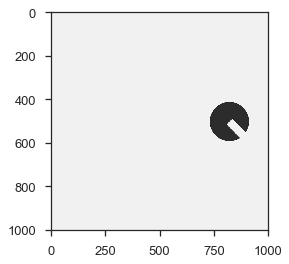

In [245]:
plt.imshow(Fp)

/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


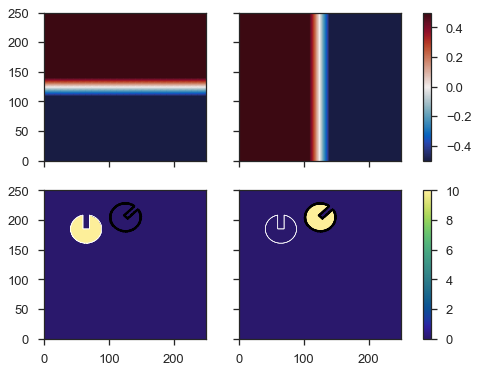

In [244]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
axu, axv, axf, axfp = axs.flatten()[:]

cf = axu.pcolormesh(xx, yy, u, vmin=-0.5, vmax=0.5, cmap=cm.balance)
_ = axv.pcolormesh(xx, yy, v, vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.colorbar(cf, ax=[axu, axv])

cf = axf.pcolormesh(xx, yy, F, vmin=0, vmax=A, cmap=cm.haline)
axf.contour(xx, yy, F, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='w')
axf.contour(xx, yy, Fp, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='k')
_ = axfp.pcolormesh(xx, yy, Fp, vmin=0, vmax=A, cmap=cm.haline)
axfp.contour(xx, yy, F, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='w')
axfp.contour(xx, yy, Fp, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='k')
plt.colorbar(cf, ax=[axf, axfp])

In [68]:
Fps[-1]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Rotational Extension

Following Germann and Zawadzki (2002), we extend the original method by dividing the displacement vector computation into $N$ steps of length $\Delta t_N$, such that $\tau = N\Delta t_N$. Then, for each time-step, we can iteratively determine $\alpha$ such that

$$ \mathbf{\alpha} = \Delta t_N\mathbf{u}\left(t_0,\mathbf{x} - \frac{\mathbf{\alpha}}{2}\right) $$

starting with the initial condition $\mathbf{\alpha} = 0$. We can compute a final displacement vector by taking the sum of these partial vectors.a

*Note* - this requires the previous kernels (array helpers and bilinear interpolation) to have been compiled already! 

### Method 1) Functional interpolation

Perhaps the "easiest" way to solve this problem is constuct a function which translates the gridded flow field into a continuous function on R2. Once we have that, thn we can actually trivally optimize the above problem for $\alpha$. To build our interpolant we'll actually create a global grid of cubic splines on our data. Then, we simply need to hard-code in our multi-variate RHS, and the solvers should be able to automatically estimate the Jacobian.


In [250]:
from scipy.optimize import root

from scipy.interpolate import interp2d, RectBivariateSpline
# ulin = interp2d(xx.ravel(), yy.ravel(), u, 'cubic')
# vlin = interp2d(xx.ravel(), yy.ravel(), v, 'cubic')
_ulin = RectBivariateSpline(x, y, u)
ulin = lambda x, y: _ulin([x, ], [y, ])[0]
_vlin = RectBivariateSpline(x, y, v)
vlin = lambda x, y: _vlin([x, ], [y, ])[0]

i, j = (7*f, 37*f)
print(i, j)
x0, y0 = x[i], y[j]
print(x0, y0)

def flin(alpha, x0, y0, pdt):
    alpha = np.asarray(alpha)
    ax, ay = alpha / 2.
    
    uu = np.array([ulin(x0-ax, y0-ay)[0], vlin(x0-ax, y0-ay)[0]])    
    return alpha - pdt*uu

dt = 50.
ndt = 5
pdt = dt / ndt

print(pdt)

x0y0s = [np.array((x0, y0)), ]
alphas = [np.zeros(2), ]
alphaP = np.array([
    -dt*ulin(x0, y0)[0], -dt*vlin(x0, y0)[0]
])
for idt in range(ndt):
    print("{:2d})".format(idt), alphas[-1])
    _x0, _y0 = x0y0s[-1]
    print(_x0, _y0)
    
    sol = root(flin, alphas[-1], args=(_x0, _y0, pdt), method='lm', tol=1e-6)#, jac=jac)
    # print(sol)
    # print(sol.x, flin(sol.x, _x0, _y0, pdt))
    if sol.success:
        alphas.append(sol.x)
        x0y0s.append(x0y0s[-1] - alphas[-1])
    

70 370
35.0 185.0
10.0
 0) [ 0.  0.]
35.0 185.0
 1) [ 14.22776911  31.07644306]
20.7722308892 153.923556942
 2) [  3.82125238  33.9642865 ]
16.9509785072 119.959270446
 3) [ -6.96679345  33.46099993]
23.9177719528 86.4982705193
 4) [-17.05924679  29.61683349]
40.9770187447 56.8814370309


70 370
[[  35.          185.        ]
 [  20.77223089  153.92355694]
 [  16.95097851  119.95927045]
 [  23.91777195   86.49827052]
 [  40.97701874   56.88143703]
 [  66.42545555   34.06583292]]


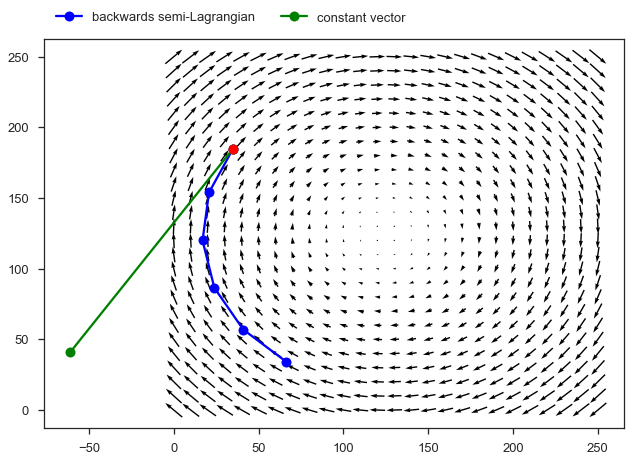

In [257]:
max_q = 25
rsx = nx // max_q
rsy = ny // max_q

print(i,j)
plt.quiver(xx[::rsx, ::rsy], yy[::rsx, ::rsy], u[::rsx, ::rsy], v[::rsx, ::rsy], 
           angles='xy', pivot='mid')

plt.plot([x0, ], [y0, ], marker='o', color='r', ms=10, zorder=10)
last = x0, y0
print(np.asarray(x0y0s))
x0s, y0s = zip(*x0y0s)
plt.plot(x0s, y0s, color='b', marker='o', ms=10, zorder=5,
         label='backwards semi-Lagrangian')
# for _x0, _y0 in x0y0s:
#     plt.plot([last[0], _x0], [last[1], _y0], color='b', marker='o', ms=10, zorder=5)
#     last = _x0, _y0
    
# Plot linear
lin = alphaP + x0y0s[0]
plt.plot([x0, lin[0]], [y0, lin[1]], color='g', marker='o', ms=10, zorder=5,
         label='constant vector')

plt.legend(loc='upper left', bbox_to_anchor=[0, 1.1], ncol=2)

# plt.xlim(x[max(i-10, 0)], x[min(i+10, nx)])
# plt.ylim(y[max(j-10, 0)], y[min(j+10, ny)])

### Method 2) Analytic Jacobian

Extend Method (1) with an analytical Jacobian.

In [249]:
from scipy.optimize import root

from scipy.interpolate import interp2d
# ulin = interp2d(xx.ravel(), yy.ravel(), u, 'cubic')
# vlin = interp2d(xx.ravel(), yy.ravel(), v, 'cubic')
_ulin = RectBivariateSpline(x, y, u, kx=1, ky=1)
ulin = lambda x, y: _ulin([x, ], [y, ])[0]
_vlin = RectBivariateSpline(x, y, v, kx=1, ky=1)
vlin = lambda x, y: _vlin([x, ], [y, ])[0]


flow_u = u.copy()
flow_v = v.copy()
data = F.copy()
dx = Δx
dy = Δy

hfact = 1e6
hx, hy = dx/hfact, dy/hfact
hi, hj = hx/dx, hy/dy
print(hi, hj)

i, j = (7*f, 37*f)
xi, yj = x[i], y[j]

def jac(alpha, x0, y0, pdt):
    alpha = np.asarray(alpha) / 2.
    ax, ay = alpha
    
    J_x_x = 1. - pdt*(ulin(x0-ax+hx, y0-ay) - ulin(x0-ax-hx, y0-ay))/2./hx
    J_x_y = pdt*(ulin(x0-ax, y0-ay+hy) - ulin(x0-ax, y0-ay-hy))/2./hy
    J_y_x = pdt*(vlin(x0-ax+hx, y0-ay) - vlin(x0-ax-hx, y0-ay))/2./hx
    J_y_y = 1. - pdt*(vlin(x0-ax, y0-ay+hy) - vlin(x0-ax, y0-ay-hy))/2./hy
    
    J = np.array([[J_x_x, J_x_y], [J_y_x, J_y_y]])
    J = J[...,-1]
    return J


def flin(alpha, x0, y0, pdt):
    alpha = np.asarray(alpha)
    ax, ay = alpha / 2.
    
    uu = np.array([ulin(x0-ax, y0-ay)[0], vlin(x0-ax, y0-ay)[0]])    
    return alpha - pdt*uu


dt = 50.
ndt = 5
pdt = dt / ndt

print(pdt)

x0y0s = [np.array((x0, y0)), ]
alphas = [np.ones(2), ]
# Single-step, constant linear vector
alphaP = np.array([
    -dt*ulin(x0,y0)[0], -dt*vlin(x0,y0)[0]
])
for idt in range(ndt):
    print("{:2d})".format(idt), alphas[-1])
    _x0, _y0 = x0y0s[-1]
    print(_x0, _y0)
    
    sol = root(flin, alphas[-1], args=(_x0, _y0, pdt), method='lm', tol=1e-6, jac=jac,
               options=dict(col_deriv=True)
    )
    # print(sol)
    print(sol.x, flin(sol.x, _x0, _y0, pdt))
    if sol.success:
        alphas.append(sol.x)
        x0y0s.append(x0y0s[-1] - alphas[-1])

1e-06 1e-06
10.0


NameError: name 'x0' is not defined

35 185
[[  35.          185.        ]
 [  20.77223256  153.92356189]
 [  16.95097807  119.9592794 ]
 [  23.91776712   86.49828228]
 [  40.97700789   56.88144941]
 [  66.42543807   34.06584306]]


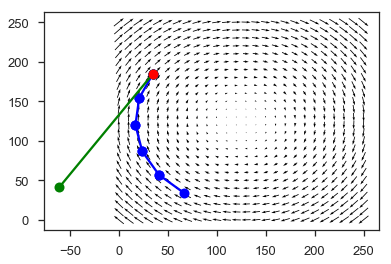

In [308]:
max_q = 25
rsx = nx // max_q
rsy = ny // max_q

print(i,j)
plt.quiver(xx[::rsx, ::rsy], yy[::rsx, ::rsy], u[::rsx, ::rsy], v[::rsx, ::rsy], 
           angles='xy', pivot='mid')

plt.plot([xi, ], [yj, ], marker='o', color='r', ms=10, zorder=10)
last = xi, yj
print(np.asarray(x0y0s))
for _x0, _y0 in x0y0s:
    plt.plot([last[0], _x0], [last[1], _y0], color='b', marker='o', ms=10, zorder=5)
    last = _x0, _y0
    
# Plot linear
lin = alphaP + x0y0s[0]
plt.plot([xi, lin[0]], [yj, lin[1]], color='g', marker='o', ms=10, zorder=5)
    

# plt.xlim(x[max(i-10, 0)], x[min(i+10, nx)])
# plt.ylim(y[max(j-10, 0)], y[min(j+10, ny)])

### Method 3) Manual Newton-Raphson iteration

In [21]:
flow_u = u.copy()
flow_v = v.copy()
data = F.copy()
dx = Δx
dy = Δy
dx_dy = np.array([dx, dy])

hfact = 1e6
hx, hy = dx/hfact, dy/hfact
hi, hj = hx/dx, hy/dy
print(hi, hj)

dt = 50.
ndt = 5
pdt = dt / ndt

i, j = (7*f, 37*f)
xi, yj = x[i], y[j]

dx_dy = np.array([dx, dy])

# Initial guess
x0y0s = [np.array((xi, yj)), ]  
ijs = [np.array((i, j)), ]  
# alpha0 = np.array([0, 0])
alpha0 = np.array([-pdt*pixel_mask(flow_u, i, j),
                   -pdt*pixel_mask(flow_v, i, j)])
alphaP = np.array([-dt*pixel_mask(flow_u, i, j),
                   -dt*pixel_mask(flow_v, i, j)])
alphas = [alpha0, ]
betas = [np.array([0, 0])]
for it in range(ndt):

    _i, _j = ijs[-1]
    print(ijs[-1], ijs[-1]*dx_dy)

    # Compute deflection vector
    _alphas = [alpha0, ]
    for ct in range(8):
        print("{:2d}) ".format(ct), _alphas[-1])
        ai, aj = _alphas[-1]
        beta = _alphas[-1]/2./dx_dy
        beta_i, beta_j = beta 
        
        # Construct Jacobian finite-differences using centered diffs and bilinear re-sampling.
        J_x_x = 1. + pdt*(pixel_mask(flow_u, _i - beta_i + hi,       _j - beta_j) - 
                          pixel_mask(flow_u, _i - beta_i - hi,       _j - beta_j))/2./hx

        J_x_y = pdt*(pixel_mask(flow_u,      _i - beta_i, _j - beta_j + hj) - 
                     pixel_mask(flow_u,      _i - beta_i, _j - beta_j - hj))/2./hy

        J_y_x = pdt*(pixel_mask(flow_v, _i - beta_i + hi,       _j - beta_j) - 
                     pixel_mask(flow_v, _i - beta_i - hi,       _j - beta_j))/2./hx

        J_y_y = 1. - pdt*(pixel_mask(flow_v,      _i - beta_i, _j - beta_j + hj) - 
                          pixel_mask(flow_v,      _i - beta_i, _j - beta_j - hj))/2./hy

        J = np.array([[J_x_x, J_x_y], [J_y_x, J_y_y]])
        Fij = np.array([
            pixel_mask(flow_u, _i - beta_i, _j - beta_j), 
            pixel_mask(flow_v, _i - beta_i, _j - beta_j)
        ])
        # Why is there an extra factor of "2" here?
        FF = _alphas[-1] - pdt*Fij

        Jinv = np.linalg.inv(J)
        d_alpha =  Jinv @ FF

        alpha = _alphas[-1] - d_alpha
        _alphas.append(alpha)

    print("{:2d}) ".format(ct+1), _alphas[-1])
    print(alpha, alpha - pdt*Fij)
    
    # Compute iterated step
    alphas.append(_alphas[-1])
    x0y0s.append(x0y0s[-1] - alphas[-1])
    ijs.append(ijs[-1] - _alphas[-1]/dx_dy)
    betas.append(_alphas[-1]/dx_dy)
    
    print(x0y0s[-1], ijs[-1], alphas[-1])

    print("--"*20)
    

1e-06 1e-06
[ 35 185] [  35.  185.]
 0)  [-19.2 -28.8]
 1)  [  3.98490562  33.1471698 ]
 2)  [ 14.05258921  32.65924362]
 3)  [ 14.44935735  31.17538008]
 4)  [ 14.25242009  31.04887725]
 5)  [ 14.22491316  31.071585  ]
 6)  [ 14.22693138  31.07663194]
 7)  [ 14.22775762  31.07657342]
 8)  [ 14.2277875   31.07645078]
[ 14.2277875   31.07645078] [  3.92435453e-05   9.56174460e-06]
[  20.7722125   153.92354922] [  20.7722125   153.92354922] [ 14.2277875   31.07645078]
----------------------------------------
[  20.7722125   153.92354922] [  20.7722125   153.92354922]
 0)  [-19.2 -28.8]
 1)  [ -6.35742891  34.39051477]
 2)  [  3.41037038  35.46139917]
 3)  [  4.01945314  34.09345774]
 4)  [  3.84920133  33.94152392]
 5)  [  3.81924279  33.95917748]
 6)  [  3.82041359  33.9643455 ]
 7)  [  3.82121804  33.9644156 ]
 8)  [  3.82126557  33.9643021 ]
[  3.82126557  33.9643021 ] [  3.63203195e-05   1.52114566e-05]
[  16.95094693  119.95924712] [  16.95094693  119.95924712] [  3.82126557  33.964

35 185
[[  35.          185.        ]
 [  20.7722125   153.92354922]
 [  16.95094693  119.95924712]
 [  23.91773527   86.49822644]
 [  40.97698669   56.88137071]
 [  66.42543797   34.06574697]]


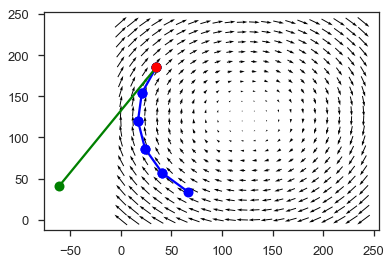

In [22]:
max_q = 20
rsx = nx // max_q
rsy = ny // max_q

print(i,j)
plt.quiver(xx[::rsx, ::rsy], yy[::rsx, ::rsy], u[::rsx, ::rsy], v[::rsx, ::rsy], 
           angles='xy', pivot='mid')

# beta = np.array([-pdt*flow_u[i, j], -pdt*flow_v[i,j]])
plt.plot([xi, ], [yj, ], marker='o', color='r', ms=10, zorder=10)
last = [xi, yj]
last = xi, yj
print(np.asarray(x0y0s))
for _x0, _y0 in x0y0s:
    plt.plot([last[0], _x0], [last[1], _y0], color='b', marker='o', ms=10, zorder=5)
    last = _x0, _y0
    
# Plot linear
lin = alphaP + x0y0s[0]
plt.plot([xi, lin[0]], [yj, lin[1]], color='g', marker='o', ms=10, zorder=5)
    
# plt.xlim(x[max(i-15, 0)], x[min(i+15, nx)])
# plt.ylim(y[max(j-15, 0)], y[min(j+15, ny)])

### Complete Implementation

Using the form above, do the rotational semi-Lagrangian scheme, but still with bilinear interpolation.

In [189]:
%timeit _solve_alpha([0., 0.], u, v, 7, 37, Δx, Δy, 1.0)
_solve_alpha([0., 0.], u, v, 7, 37, Δx, Δy, 1.0)

6.21 µs ± 394 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


[-3.4693198541173462, 3.832490882334122]

In [197]:
%timeit _solve_alpha([0., 0.], u, v, 7, 37, Δx, Δy, 1.0)
_solve_alpha([0., 0.], u, v, 7, 37, Δx, Δy, 1.0)

2.33 µs ± 43.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


[-3.469325617277262, 3.8324958599140277]

In [228]:
%timeit _solve_alpha([0., 0.], u, v, 7, 37, Δx, Δy, 1.0)
_solve_alpha([0., 0.], u, v, 7, 37, Δx, Δy, 1.0)

2.48 µs ± 152 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


[-3.469325617277262, 3.8324958599140277]

In [31]:
from numba import jit, njit, prange

DX_DY = np.array([Δx, Δy])
MAX_ITER = 2
HFACT = 1e-6

@jit(nopython=True, nogil=True)
def _solve_alpha(alpha0, flow_u, flow_v, i, j, dx, dy, pdt):
    
    # Compute deflection vector
    ai, aj = alpha0[0], alpha0[1]
    
    # Step size for gradient estimation
    hx, hy = dx/HFACT, dy/HFACT
    hi, hj = hx/dx, hy/dy
    
    for ct in range(MAX_ITER):
        # ai, aj = _alpha[0], _alpha[1]
        beta_i, beta_j = ai/2./dx, aj/2./dy
        
        # Construct Jacobian finite-differences using centered diffs and bilinear re-sampling.
        J_x_x = 1. + pdt*(pixel_mask(flow_u, i - beta_i + HFACT, j - beta_j) - 
                          pixel_mask(flow_u, i - beta_i - HFACT, j - beta_j))/2./hx

        J_x_y = pdt*(pixel_mask(flow_u, i - beta_i, j - beta_j + HFACT) - 
                     pixel_mask(flow_u, i - beta_i, j - beta_j - HFACT))/2./hy

        J_y_x = pdt*(pixel_mask(flow_v, i - beta_i + HFACT, j - beta_j) - 
                     pixel_mask(flow_v, i - beta_i - HFACT, j - beta_j))/2./hx

        J_y_y = 1. - pdt*(pixel_mask(flow_v, i - beta_i, j - beta_j + hj) - 
                          pixel_mask(flow_v, i - beta_i, j - beta_j - hj))/2./hy
        # J = np.zeros((2, 2))
        # J[0, 0] = J_x_x
        # J[0, 1] = J_x_y
        # J[1, 0] = J_y_x
        # J[1, 1] = J_y_y
        # J = np.array([[J_x_x, J_x_y], [J_y_x, J_y_y]])
        
        # Compute current RHS
        Fi = ai - pdt*pixel_mask(flow_u, i - beta_i, j - beta_j)
        Fj = aj - pdt*pixel_mask(flow_v, i - beta_i, j - beta_j)
        # FF = np.array([Fi, Fj])
        
        # Perform NR step
        # Jinv = np.linalg.inv(J)
        # d_alpha =  Jinv @ FF
        
        # Manually compute RHS
        den = 1./(J_x_x*J_y_y - J_x_y*J_y_x)
        Jia = J_y_y / den
        Jib = -J_x_y / den
        Jic = -J_y_x / den
        Jid = J_x_x / den
        ai = ai - (Jia*Fi + Jib*Fj)
        aj = aj - (Jic*Fi + Jid*Fj)
        
        # ai, aj = ai - d_alpha[0], aj - d_alpha[1]
        
        #_alpha = np.array([nai, naj])

    return [ai, aj]


@njit
def calc_displacement(flow_u, flow_v, i0, j0, dx, dy, dt, ndt):
    """ Compute sequential, partial displacements to trace the
    origin point in a rotational flow field.
    
    Returns the fractional integer displacements, not the actual
    metric displacement vector.
    
    """
    
    # Compute the partial timesteps
    pdt = dt / ndt
    
    # Set initial i/j coordinates and displacement components
    _i, _j = i0, j0
    _ai, _aj = 0., 0.
    for it in range(ndt):
        _ai, _aj = _solve_alpha([_ai, _aj], flow_u, flow_v, _i, _j, dx, dy, pdt)
        _i -= _ai/dx
        _j -= _aj/dy
        
    return [_i, _j]        


@jit(nopython=True, parallel=True)
def advect_field_rot(flow_u, flow_v, data, 
                     dx=Δx, dy=Δy, dt=5.0, ndt=2,
                     bkg=BACKGROUND):
    """ Compute backwards semi-Lagrangian advection with partial steps to 
    account for non-linearities in the given flow and data fields.
    
    Parameters
    ----------
    flow_{u, v} : numpy.ndarrays rank 2
        U and V components of the vector field, in m/s
    data : numpy.ndarray of rank 2
        The tracer field to advect along with the given flow field.
    d{x, y} : floats
        Constant grid-spacing in the x- and y- directions, in m
    dt : float
        Advection time step, in s
    ij : 2-tuple of ints
        Short-circuit the aglorithm by computing the backwards step and interpolant
        at the indicated grid location
        
    Returns
    -------
    Rank-2 array containing the advected flow after a time of `dt` seconds
    
    """
    
    new_data = np.ones_like(data)*bkg
    nx, ny = new_data.shape
    
    # Set up the iterative vector computations
    pdt = dt / ndt

    # For each grid cell...
    # nn = itertools.product(range(nx), range(ny))
    
    for j in range(0, ny):
        for i in range(0, nx):
            
            # ... compute the displacement vector ...
#             ai, aj = 0., 0.
#             _i, _j = i, j
#             for it in range(ndt):
#                 ai, aj = _solve_alpha([ai, aj], flow_u, flow_v, _i, _j, dx, dy, pdt)
#                 _i -= ai/dx
#                 _j -= aj/dy
            _i, _j = calc_displacement(flow_u, flow_v, i, j, dx, dy, dt, ndt)

            # ... and copy the source destination into its new location
            new_data[i,j] = pixel_mask(data, _i, _j, bkg)
            
    # for j, i in prange(product(range(0, ny), range(0, nx))):
    #     new_data[i, j] = pixel_mask(data, i - dt*flow_u[i,j]/dx, j - dt*flow_v[i,j]/dy, bkg)
            
    return new_data

In [32]:
Fp = F.copy()
dt = 25.
Fps = [Fp, ]

t_end = 360.
t, i = 0, 0
ts = [t, ]
while t < t_end:
    print("({:3d} {:3.1f}s)".format(i, t))

    Fp = advect_field_rot(u, v, Fps[-1], dt=dt, ndt=5)    
    Fps.append(Fp)
    ts.append(t+dt)
    
    i += 1
    t += dt
print("... done", t)

ds = make_dataset(Fps, x, y, ts, u, v)

(  0 0.0s)
(  1 25.0s)
(  2 50.0s)
(  3 75.0s)
(  4 100.0s)
(  5 125.0s)
(  6 150.0s)
(  7 175.0s)
(  8 200.0s)
(  9 225.0s)
( 10 250.0s)
( 11 275.0s)
( 12 300.0s)
( 13 325.0s)
( 14 350.0s)
... done 375.0


In [33]:
ds.to_netcdf('hat.slb.bilinear.wavy.nc')

/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':
/Users/daniel/anaconda/envs/scraping_env/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


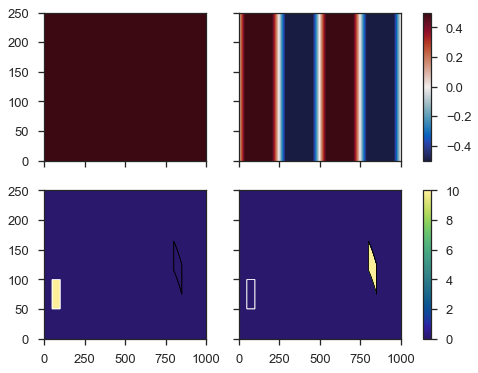

In [34]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
axu, axv, axf, axfp = axs.flatten()[:]

cf = axu.pcolormesh(xx, yy, u, vmin=-0.5, vmax=0.5, cmap=cm.balance)
_ = axv.pcolormesh(xx, yy, v, vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.colorbar(cf, ax=[axu, axv])

cf = axf.pcolormesh(xx, yy, F, vmin=0, vmax=A, cmap=cm.haline)
axf.contour(xx, yy, F, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='w')
axf.contour(xx, yy, Fp, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='k')
_ = axfp.pcolormesh(xx, yy, Fp, vmin=0, vmax=A, cmap=cm.haline)
axfp.contour(xx, yy, F, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='w')
axfp.contour(xx, yy, Fp, levels=np.linspace(0, A+0.1, A/2), linewidths=0.5, colors='k')
plt.colorbar(cf, ax=[axf, axfp])

### Timing - CV vs SLB

In [235]:
# NEW
%timeit advect_field_rot(u[::1, ::1], v[::1, ::1], F[::1, ::1], dt=5., ndt=5) 

702 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


----
DO NOT TOUCH

In [216]:
%timeit advect_field_rot(u[::1, ::1], v[::1, ::1], F[::1, ::1], dt=5., ndt=5) 

1.22 s ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [217]:
%timeit advect_field_rot(u[::2, ::2], v[::2, ::2], F[::2, ::2], dt=5., ndt=5) 

301 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [218]:
%timeit advect_field_rot(u[::5, ::5], v[::5, ::5], F[::5, ::5], dt=5., ndt=5) 

48.6 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [215]:
%timeit advect_field_rot(u[::10, ::10], v[::10, ::10], F[::10, ::10], dt=5., ndt=5) 

11.3 ms ± 626 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [151]:
%timeit advect_field(u[::1, ::1], v[::1, ::1], F[::1, ::1], dt=5.) 

6.84 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [150]:
%timeit advect_field(u[::2, ::2], v[::2, ::2], F[::2, ::2], dt=5.) 

1.86 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [149]:
%timeit advect_field(u[::5, ::5], v[::5, ::5], F[::5, ::5], dt=5.) 

495 µs ± 62.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [148]:
%timeit advect_field(u[::10, ::10], v[::10, ::10], F[::10, ::10], dt=5.) 

327 µs ± 96.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
import pandas as pd

df = pd.DataFrame([
    [1.22, .0364, 1, 'slb'],  
    [.301, .019, 2, 'slb'],
    [.0486, .00196, 5, 'slb'],
    [.0113, 626e-6, 10, 'slb'],  
    [10.4, .325, 1, 'slb_linalg'],  
    [2.47, .0207, 2, 'slb_linalg'],
    [.408, .00929, 5, 'slb_linalg'],
    [.113, .00744, 10, 'slb_linalg'],  
    [.00684, 559e-6, 1, 'cv'],  
    [.00186, 224e-6, 2, 'cv'],
    [495e-6, 62.4e-6, 5, 'cv'],
    [327e-6, 96.3e-6, 10, 'cv'],  
], columns=['time', 'std', 'nfac', 'method'])
df['nx'] = nx/df.nfac

Text(0.5,0,'nx')

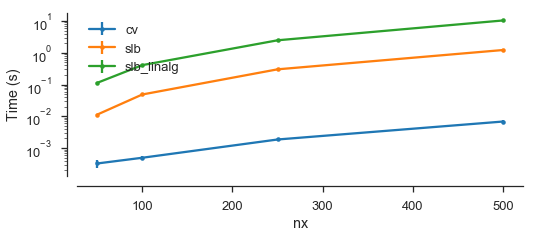

In [222]:
import seaborn as sns

# fg = sns.factorplot('nfac', 'time', hue='method', data=df, aspect=2)
# fg.ax.semilogy()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

groups = df.groupby('method')
for method, gdf in groups:
    ax.errorbar('nx', 'time', yerr='std', data=gdf, 
                label=method, marker='.')
    
ax.semilogy()
sns.despine(fig, offset=10)
ax.legend()
ax.set_ylabel("Time (s)")
ax.set_xlabel("nx")



### Quick animation

In [258]:
dsl = xr.open_dataset('test.seed.nc')
dsb = xr.open_dataset('test.seed_rot.nc')
diff = dsl-dsb

In [261]:
dsl.info()

xarray.Dataset {
dimensions:
	time = 73 ;
	x = 501 ;
	y = 501 ;

variables:
	float64 q(time, x, y) ;
	float64 v(x, y) ;
		v:units = m/s ;
		v:long_name = meridional wind ;
	float64 u(x, y) ;
		u:units = m/s ;
		u:long_name = zonal wind ;
	float64 x(x) ;
		x:units = m ;
		x:long_name = x-coordinate ;
	float64 y(y) ;
		y:units = m ;
		y:long_name = y-coordinate ;
	datetime64[ns] time(time) ;
		time:long_name = time ;

// global attributes:
	:Conventions = CF-1.7 ;
}

In [291]:
!mkdir tmp

In [297]:
from ccpy.plot import get_figsize
from tqdm import tqdm

plt.ioff()

for it in tqdm(range(len(dsl.time))):

    nrows, ncols = 1, 3
    figsize = get_figsize(nrows, ncols, size=4, aspect=1.4)
    fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=figsize)
    axl, axm, axr = axs

    dali = dsl.isel(time=it)
    dabi = dsb.isel(time=it)
    diff = dali - dabi

    nx, ny = len(dsl.x), len(dsl.y)
    max_q = 12
    rsx = nx // max_q
    rsy = ny // max_q

    qm = dali.q.plot.pcolormesh('x', 'y', ax=axl, add_colorbar=False,
                               rasterized=True)
    axl.set_title("constant vector")
    dabi.q.plot.pcolormesh('x', 'y', ax=axm, add_colorbar=False,
                          rasterized=True)
    axm.set_title("backwards semi-Lagrangian")
    qd = diff.q.plot.pcolormesh('x', 'y', ax=axr, add_colorbar=True,
                                vmin=-10., vmax=10., cmap='RdBu_r')
    for ax in [axl, axm]:
        ax.quiver(dali.x[::rsx], dali.y[::rsy], 
                  dali.u[::rsx,::rsy].T, dali.v[::rsx,::rsy].T, 
                  angles='xy', pivot='mid', scale=40., color='w')
    plt.colorbar(qm, ax=[axl, axm])
    
    plt.savefig("tmp/{:03d}.png".format(it), dpi=150)
    
    plt.close()
    
    # break

plt.ion()

100%|██████████| 73/73 [02:02<00:00,  1.68s/it]
